In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter
import warnings

warnings.filterwarnings("ignore")

In [25]:
class Evolutionary_Algorithm:
    __slots__ = [
        "circle_radius",
        "mutation_rate",
        "crossover_rate",
        "number_of_generations",
        "population_size",
        "population",
        "problem_dim",
        "hall_of_fame",
    ]

    def __init__(
        self,
        circle_radius,
        mutation_rate=0.7,
        crossover_rate=0.7,
        number_of_generations=50,
        population_size=100,
    ):
        self.circle_radius = circle_radius
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = None
        self.problem_dim = None
        self.hall_of_fame = []

    def _generate_population(self, n_genes):
        pass

    def _generate_individual(self, n_trials, rectangles):
        solution = []
        score = 0
        # rectangles_by_value = sorted(rectangles, key=lambda x: x[2])
        for i in range(n_trials):
            x = np.random.uniform(-self.circle_radius, self.circle_radius)
            y = np.random.uniform(-self.circle_radius, self.circle_radius)
            # left bottom corner in circle
            if np.sqrt(x**2 + y**2) > self.circle_radius:
                continue
            rectangle = rectangles[np.random.randint(0, len(rectangles))]
            # top right corner in circle
            if (
                np.sqrt((x + rectangle[0]) ** 2 + (y + rectangle[1]) ** 2)
                > self.circle_radius
            ):
                continue
            # top left corner in circle
            if (np.sqrt((x) ** 2 + (y + rectangle[1]) ** 2)) > self.circle_radius:
                continue
            # bottom right corner in circle
            if (np.sqrt((x + rectangle[0]) ** 2 + (y) ** 2)) > self.circle_radius:
                continue
            overlap = False
            for s in solution:
                # check if rectangle overlaps with any other rectangle
                if (
                    (x < s[0] + s[2])
                    and (x + rectangle[0] > s[0])
                    and (y < s[1] + s[3])
                    and (y + rectangle[1] > s[1])
                ):
                    overlap = True
                    break

            if overlap:
                continue
            solution.append([x, y, rectangle[0], rectangle[1], rectangle[2]])
            score += rectangle[2]
        return np.array(solution), score

    def _mutation(self, individual):
        # in the future add 4 sorted list for each individual and maybe create class for individual
        mutations = ["right", "top"]
        mutation = np.random.choice(mutations)
        index_of_rectangle_to_mutate = np.random.randint(0, len(individual))
        rectangle_to_mutate = individual[index_of_rectangle_to_mutate]
        left, bottom, width, height, _ = rectangle_to_mutate
        right, top = left + width, bottom + height

        if mutation == "top":
            list_of_potential_vertical_collisions = []
            for rectangle in individual:
                if (
                    left < rectangle[0] < right
                    or left < rectangle[0] + rectangle[2] < right
                    or (rectangle[0] < left and rectangle[0] + rectangle[2] > right)
                ):
                    list_of_potential_vertical_collisions.append(rectangle)

            highest_bottom = float("inf")
            for rectangle in list_of_potential_vertical_collisions:
                if rectangle[1] > top and rectangle[1] < highest_bottom:
                    highest_bottom = rectangle[1]
            # print(rectangle_to_mutate)
            # print(highest_bottom)
            # self._visualize_individual(
            #     circle_radius=self.circle_radius,
            #     rectangles=list_of_potential_vertical_collisions,
            #     selected_rectangle=rectangle_to_mutate,
            # )
            if highest_bottom == float("inf"):
                # calculate at which point the rectangle will touch the circle
                highest_bottom = min(
                    np.sqrt(self.circle_radius**2 - left**2),
                    np.sqrt(self.circle_radius**2 - right**2),
                )

            individual[index_of_rectangle_to_mutate][1] = (
                highest_bottom - rectangle_to_mutate[3]
            )
            # self._visualize_individual(
            #     circle_radius=self.circle_radius,
            #     rectangles=list_of_potential_vertical_collisions,
            #     selected_rectangle=individual[index_of_rectangle_to_mutate],
            # )

        if mutation == "right":
            list_of_potential_horizontal_collisions = []
            for rectangle in individual:
                if (
                    bottom < rectangle[1] < top
                    or bottom < rectangle[1] + rectangle[3] < top
                    or (rectangle[1] < bottom and rectangle[1] + rectangle[3] > top)
                ):
                    list_of_potential_horizontal_collisions.append(rectangle)

            rightest_left = float("inf")
            for rectangle in list_of_potential_horizontal_collisions:
                if rectangle[0] > right and rectangle[0] < rightest_left:
                    rightest_left = rectangle[0]

            self._visualize_individual(
                circle_radius=self.circle_radius,
                rectangles=list_of_potential_horizontal_collisions,
                selected_rectangle=rectangle_to_mutate,
            )

            if rightest_left == float("inf"):
                rightest_left = min(
                    np.sqrt(self.circle_radius**2 - top**2),
                    np.sqrt(self.circle_radius**2 - bottom**2),
                )

            individual[index_of_rectangle_to_mutate][0] = (
                rightest_left - rectangle_to_mutate[2]
            )

            self._visualize_individual(
                circle_radius=self.circle_radius,
                rectangles=list_of_potential_horizontal_collisions,
                selected_rectangle=individual[index_of_rectangle_to_mutate],
            )

    def _crossover(self, parent1, parent2):
        pass

    def _evaluate_population(self):
        pass

    def _tournament_selection(self, fitness):
        probabilities = fitness / np.sum(fitness)
        return self.population[
            np.random.choice(
                range(len(self.population)),
                p=probabilities,
                size=self.population_size - len(self.hall_of_fame[-1]),
                replace=True,
            )
        ]

    def _select_individual(self, n=1):
        return self.population[
            np.random.choice(range(self.population_size), size=n, replace=False)
        ]

    def _visualize_individual(self, circle_radius, rectangles, selected_rectangle=None):
        plt.figure(figsize=(6, 6))
        plt.xlim(-circle_radius * 1.03, circle_radius * 1.03)
        plt.ylim(-circle_radius * 1.03, circle_radius * 1.03)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.gca().add_artist(
            plt.Circle(
                (0, 0),
                circle_radius,
                fill=False,
                color="black",
                linestyle="--",
                linewidth=3.5,
                zorder=100,
            )
        )
        # fill it with 214, 250, 172 and 0.5 alpha
        plt.gca().add_artist(
            plt.Circle(
                (0, 0),
                circle_radius,
                fill=True,
                color=(108 / 255, 240 / 255, 136 / 255),
                alpha=0.3,
            )
        )
        for rectangle in rectangles:
            plt.gca().add_artist(
                plt.Rectangle(
                    (rectangle[0], rectangle[1]),
                    rectangle[2],
                    rectangle[3],
                    fill=False,
                    color="black",
                    zorder=100,
                )
            )
            # fill it with 234, 168, 240
            plt.gca().add_artist(
                plt.Rectangle(
                    (rectangle[0], rectangle[1]),
                    rectangle[2],
                    rectangle[3],
                    fill=True,
                    color=(234 / 255, 168 / 255, 240 / 255),
                    alpha=0.7,
                )
            )

        if selected_rectangle is not None:
            plt.gca().add_artist(
                plt.Rectangle(
                    (selected_rectangle[0], selected_rectangle[1]),
                    selected_rectangle[2],
                    selected_rectangle[3],
                    fill=True,
                    color="orange",
                    alpha=0.7,
                )
            )
            # vertical dashed line at the right edge of the rectangle extended to the circle
            plt.plot(
                [
                    selected_rectangle[0] + selected_rectangle[2],
                    selected_rectangle[0] + selected_rectangle[2],
                ],
                [
                    selected_rectangle[1] - 2 * circle_radius,
                    selected_rectangle[1] + selected_rectangle[3] + 2 * circle_radius,
                ],
                linestyle="--",
                color="black",
            )
            # vertical dashed line at the left edge of the rectangle extended to the circle
            plt.plot(
                [selected_rectangle[0], selected_rectangle[0]],
                [
                    selected_rectangle[1] - 2 * circle_radius,
                    selected_rectangle[1] + selected_rectangle[3] + 2 * circle_radius,
                ],
                linestyle="--",
                color="black",
            )
            # horizontal dashed line at the top edge of the rectangle extended to the circle
            plt.plot(
                [
                    selected_rectangle[0] - 2 * circle_radius,
                    selected_rectangle[0] + selected_rectangle[2] + 2 * circle_radius,
                ],
                [
                    selected_rectangle[1] + selected_rectangle[3],
                    selected_rectangle[1] + selected_rectangle[3],
                ],
                linestyle="--",
                color="black",
            )
            # horizontal dashed line at the bottom edge of the rectangle extended to the circle
            plt.plot(
                [
                    selected_rectangle[0] - 2 * circle_radius,
                    selected_rectangle[0] + selected_rectangle[2] + 2 * circle_radius,
                ],
                [selected_rectangle[1], selected_rectangle[1]],
                linestyle="--",
                color="black",
            )

    def optimize(self, function_to_optimize, silent=False):
        # initialize the population
        self.function_to_optimize = function_to_optimize
        self.problem_dim = function_to_optimize.__code__.co_argcount
        self._generate_population(self.problem_dim)
        best_evaluation_in_iteration = []
        best_solution_in_iteration = []

        # main algorithm loop
        for generation in range(self.number_of_generations):

            # crossover
            children = np.zeros(
                (2 * len(range(0, self.population_size, 2)), self.problem_dim)
            )
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self._select_individual(n=2)
                children[i], children[i + 1] = self._crossover(parent1, parent2)
            self.population = np.vstack([self.population, children])

            # mutation
            # we mutate every individual in the population not random one
            mutated = np.zeros((self.population_size, self.problem_dim))
            for i in range(self.population_size):
                individual = self._select_individual()
                mutated[i] = self._mutation(individual)
            self.population = np.vstack([self.population, mutated])

            # evaluate the population and log the best solution
            fitness = self._evaluate_population()
            if not silent:
                print(
                    f"iter: {generation}, best: {np.min(fitness)} for {['%.3f' % n for n in self.population[self.hall_of_fame[-1][0]]]}"
                )

            best_evaluation_in_iteration.append(np.min(fitness))
            best_solution_in_iteration.append(self.population[self.hall_of_fame[-1][0]])

            # create new population
            self.population = np.vstack(
                [
                    self.population[self.hall_of_fame[-1]],
                    self._tournament_selection(fitness),
                ]
            )

        return best_evaluation_in_iteration, best_solution_in_iteration

In [26]:
r800 = pd.read_csv("./../data/genetics/r800.csv", header=None).values

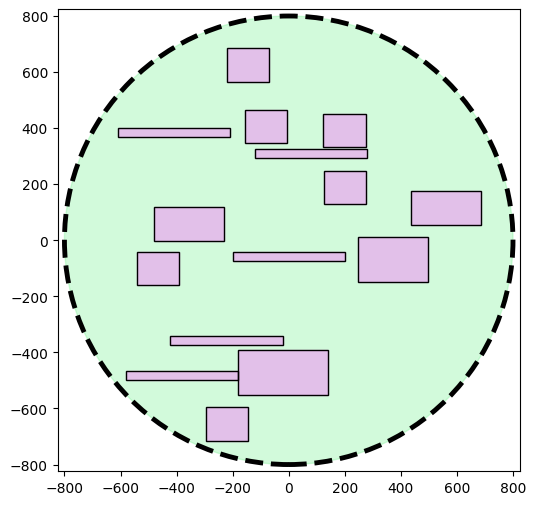

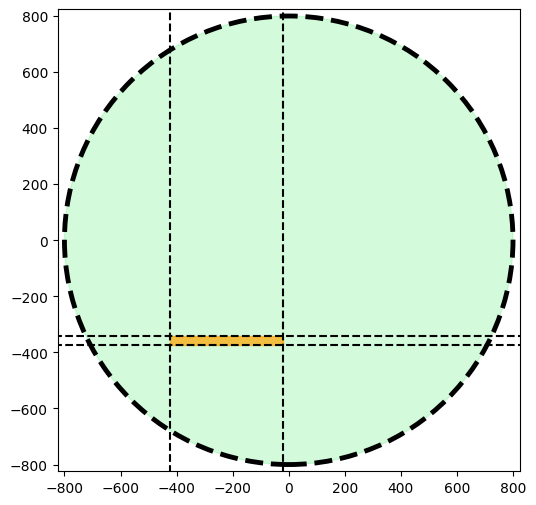

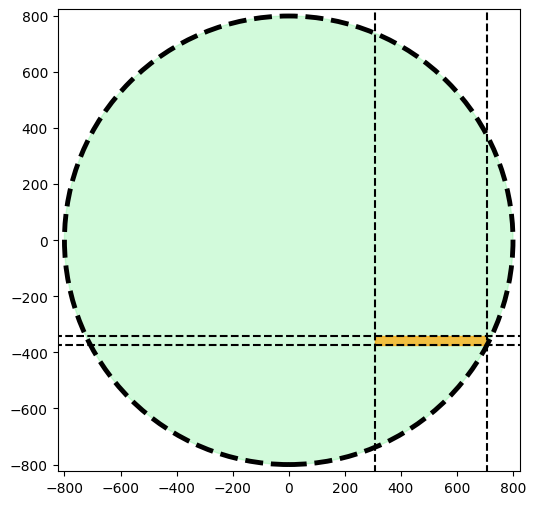

In [30]:
ea = Evolutionary_Algorithm(
    800,
    mutation_rate=0.7,
    crossover_rate=0.7,
    number_of_generations=50,
    population_size=100,
)
indiv = ea._generate_individual(100, r800)
# print(indiv[0])
ea._visualize_individual(800, indiv[0])
ea._mutation(indiv[0])

## Problem visualizations

In [378]:
def visualize_problem(size, rectangles, name, scaling_factor=2):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xlim([0, 2.2 * size])
    ax.set_ylim([0, 2.2 * size])
    ax.spines["bottom"].set_color("gray")
    ax.spines["top"].set_color("gray")
    ax.spines["right"].set_color("gray")
    ax.spines["left"].set_color("gray")
    ax.xaxis.label.set_color("gray")
    ax.yaxis.label.set_color("gray")
    ax.tick_params(axis="x", colors="gray")
    ax.tick_params(axis="y", colors="gray")

    ax.set_title("Object to cut from")
    ax.add_patch(
        plt.Circle((size * 1.1, size * 1.1), size, fill=True, color="lightblue")
    )

    print(np.array(ax.get_position()).flatten())

    ax2 = fig.add_axes(
        [
            0.82125,
            0.11,
            0.82125 - 0.22375,
            0.88 - 0.11,
        ]
    )
    ax2.set_xlim([0, 2.2 * size])
    ax2.set_ylim([0, 2.2 * size])
    ax2.axis("off")

    ax2.set_title("    Rectangles", loc="left")
    df_hight = 300
    for rectangle in rectangles:
        x = 100
        y = df_hight
        df_hight = df_hight + rectangle[1] * scaling_factor
        ax2.add_patch(
            plt.Rectangle(
                (x, y),
                rectangle[0],
                rectangle[1],
                fill=True,
                color="pink",
                edgecolor="black",
            )
        )
        ax2.add_patch(
            plt.Rectangle(
                (x, y),
                rectangle[0],
                rectangle[1],
                fill=False,
                color="black",
            )
        )

    fig.suptitle(
        f"       Visualization of {name} cutting problem ", fontsize=20, y=1.03
    )
    plt.show()

In [5]:
r800 = pd.read_csv("./../data/genetics/r800.csv", header=None).values
r800

array([[250, 120, 100],
       [320, 160, 500],
       [250, 160, 600],
       [150, 120,  40],
       [400,  30, 400]])

[0.22375 0.11    0.80125 0.88   ]


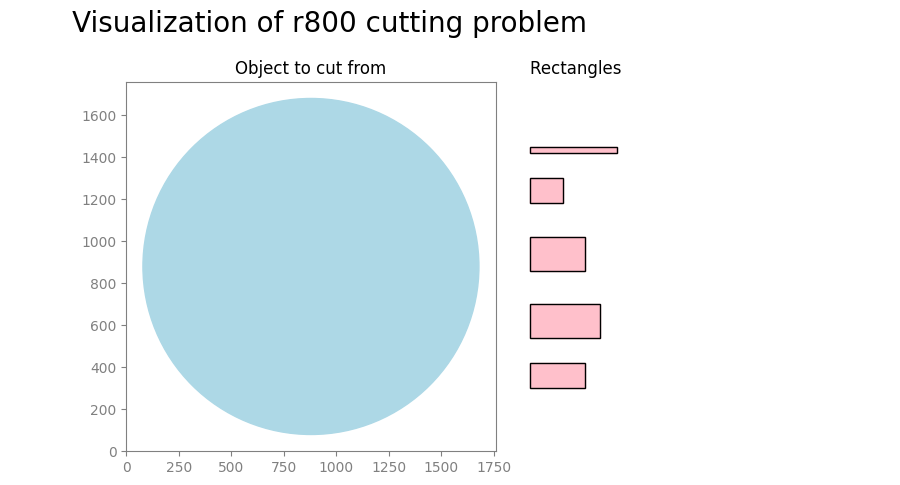

In [380]:
visualize_problem(800, r800, "r800")

In [345]:
r850 = pd.read_csv("./../data/genetics/r850.csv", header=None).values

[0.22375 0.11    0.80125 0.88   ]


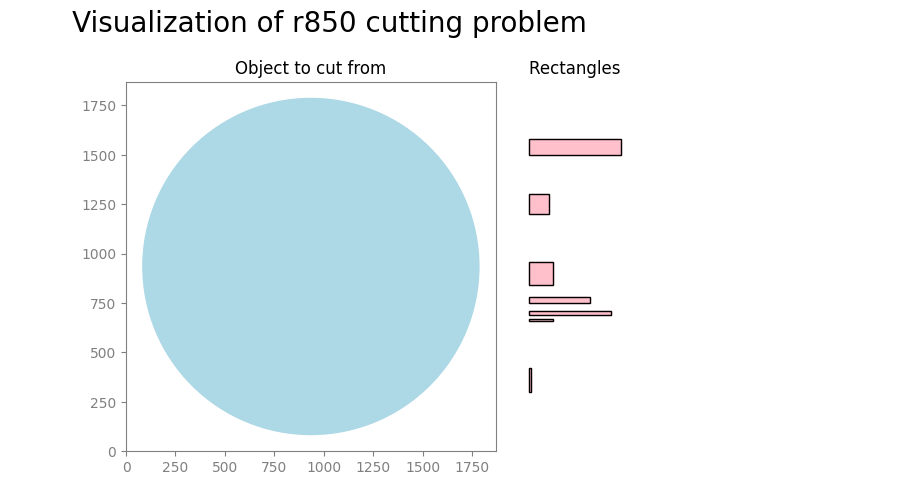

In [354]:
visualize_problem(850, r850, "r850", scaling_factor=3)

[0.22375 0.11    0.80125 0.88   ]


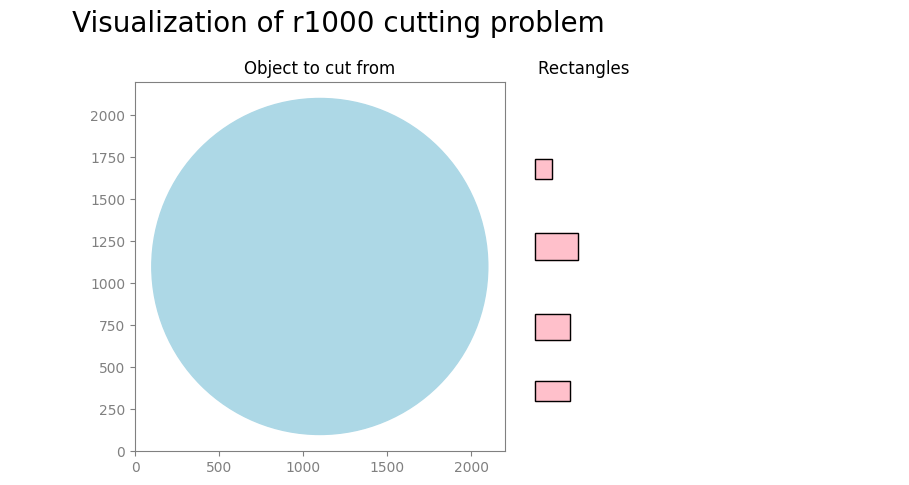

In [357]:
r1000 = pd.read_csv("./../data/genetics/r1000.csv", header=None).values
visualize_problem(1000, r1000, "r1000", scaling_factor=3)

[0.22375 0.11    0.80125 0.88   ]


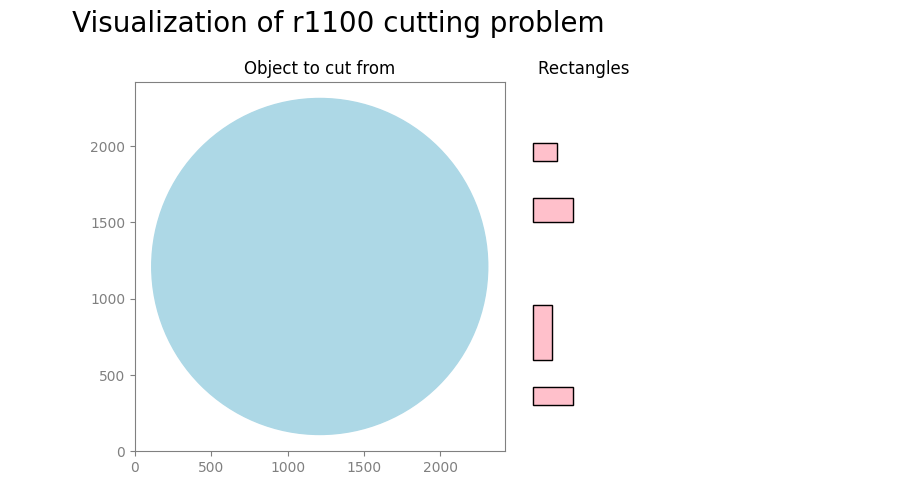

In [360]:
r1100 = pd.read_csv("./../data/genetics/r1100.csv", header=None).values
visualize_problem(1100, r1100, "r1100", scaling_factor=2.5)

[0.22375 0.11    0.80125 0.88   ]


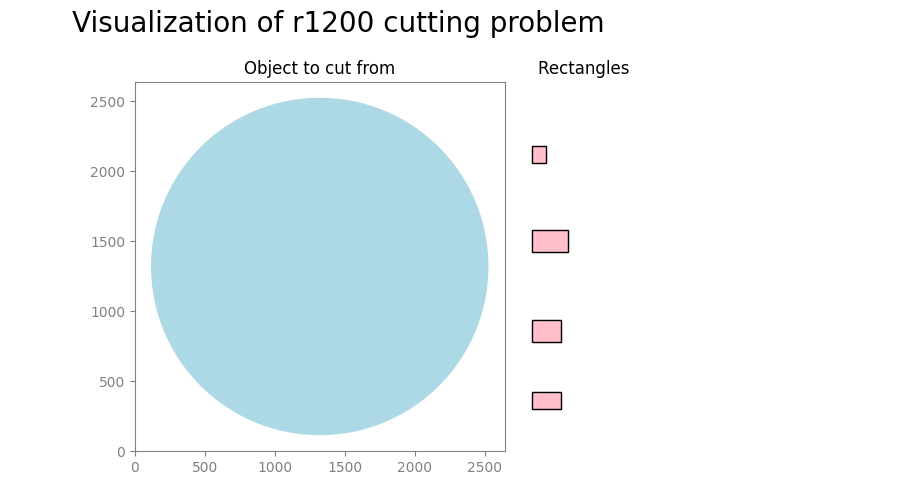

In [362]:
r1200 = pd.read_csv("./../data/genetics/r1200.csv", header=None).values
visualize_problem(1200, r1200, "r1200", scaling_factor=4)

## initialization visualizations